<a href="https://colab.research.google.com/github/koshal123/deep-learning-challenge-head_circumference_challenge-/blob/master/grand_challenge_HC_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Test/Train Data from Google Drive

In [0]:
 !pip install -U -q PyDrive ## we will have to install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Accessing the training data
#downloading training images from google -drive
training_data = drive.CreateFile({'id':'1wfT8FqrxTpf-384jH1S9ec53uk1cktp9'})
training_data.GetContentFile('training_set.zip')
!unzip training_set.zip

In [0]:
#Accessing the test data from google drive
test_data = drive.CreateFile({'id':'1S7QNdVXH9LHUvT29iVpSv9DQQGu4qefE'})
test_data.GetContentFile('test_set.zip')
!unzip test_set.zip 

In [0]:
#Creating Empty space to store test_images Mask
test_segmentation = drive.CreateFile({'id':'1yPD2pV3VRXTwcXzzEZnbsS-3g9K-cVuE'})
test_segmentation.GetContentFile('test_segmentation.zip')
!unzip test_segmentation.zip

Archive:  test_segmentation.zip
   creating: segmentation_test/


#Importing pixel size information of training set and test set from G-Drive

In [92]:
import pandas as pd
test_pixel = pd.read_csv('/content/drive/My Drive/test_set_pixel_size.csv')
test_pixel.head()

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203


In [93]:
training_pixel = pd.read_csv('/content/drive/My Drive/training_set_pixel_size_and_hc.csv')
training_pixel.head()

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


#Setting cuda as our device, Dynamically by using code:

In [0]:
import torch
import os 
import cv2

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Run the below cells only once per colab session

**Replacing the training set images with their masks but not saving them in Drive**

In [0]:
def mask_generator(im):
  imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(imgray,127,255,0)
  useless0,contours, useless1 = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)      
  ellipse = cv2.fitEllipse(contours[0])
  return cv2.ellipse(im,ellipse,(255,255,255),-1)

**Checking the above function**

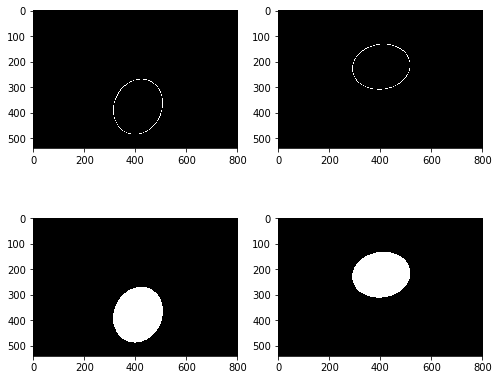

In [97]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (30,7))
for index in range(2):
  file_path = os.path.join('/content/training_set', training_pixel.iloc[index, 0].replace('.png','_Annotation.png'))
 
  ax = fig.add_subplot(2, 7, index+1)           
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(mask_generator(cv2.imread(file_path)))      

In [0]:
for index in range(len(training_pixel)):
    file_path = os.path.join('/content/training_set', training_pixel.iloc[index, 0].replace('.png','_Annotation.png'))
    im = cv2.imread(file_path)
    mask = mask_generator(im)
    cv2.imwrite(file_path, mask)

#Don't run above cell again

importing libraries to be used

In [0]:
from tqdm import tqdm_notebook 
import copy
import glob
from PIL import Image
import torchvision
import torch.utils.data
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

#mount drive in every colab session 

In [100]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


#Saving mask generation for whole training set

**mask generation is only once,,  as otherwise images were unnecessary repeats in the same folder**

In [0]:
def generate_mask(source_file_path, dest_file_path):
    file_names = sorted([file for _,_,files in os.walk(source_file_path) for file in files])
    for i, file_name in enumerate(file_names):
        if i % 2 != 0:
            im = cv2.imread(source_file_path+file_name)
            imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            ret,thresh = cv2.threshold(imgray,127,255,0)
            im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            ellipse = cv2.fitEllipse(contours[0])
            im1 = cv2.ellipse(im,ellipse,(255,255,255),-1)
            image_name = file_name.replace('Annotation', 'Mask')
            cv2.imwrite(dest_file_path+image_name, im1)
    
    return 1

**the first folder denotes the path of my training_set_images     AND  the second folder denotes the path at which we want to save the mask of training_set**

**And only these paths are used in the dataloader with X_train and Y_train respectevily**

In [0]:
# generate_mask('/content/training_set/','/content/drive/My Drive/Mask_HC18/') 


#Changing dataset to Torch form

In [0]:
class CHALLENGE18(torch.utils.data.Dataset):
  def __init__(self, png_images, transform_X=None,transform_Y = None,train=True):
    self.X_train = glob.glob('/content/training_set/*HC.png')
    
    self.Y_train = glob.glob('/content/drive/My Drive/Mask_HC18/*')
    self.transform_X = transform_X
    self.transform_Y = transform_Y
    
   
    
    self.png_images = png_images
    
  def __len__(self):
    if self.png_images == "train":
      return len(self.X_train)
    else:
      print("code is wrong")
      
  def __getitem__(self,idx):
    if self.png_images == "train":
      
      X=np.array(Image.open(self.X_train[idx]).resize((572,572))).reshape(572,572,1) #as per U-net paper
      X = self.transform_X(X)
      #print(self.X_train[idx])
      name = self.X_train[idx].split('/')
      name2 = self.Y_train[idx].split('/')
      #print(name[3])
      Y=np.array(Image.open(self.Y_train[idx].replace(name2[5], name[3]).replace('.png','_Mask.png')).convert('L').resize((572,572))).reshape(572,572,1)
      Y = self.transform_Y(Y)
      
      #print(name2[5])
      #print(self.Y_train[idx].replace(name2[5], name[3]).replace('.png','_Mask.png'))
      
      return X, Y
    
    else:
      print("code is wrong")

#Normalizing image between [0,1]

In [0]:
transform_X = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, ), (0.5, ))])
transform_Y = transforms.Compose([transforms.ToTensor()])
total_images = CHALLENGE18("train",transform_Y=transform_Y, transform_X = transform_X)

In [104]:
len(total_images)

999

In [0]:
x, y = total_images[555]

**Cross-checking the shape of x and y to being sure**

In [106]:
x.shape

torch.Size([1, 572, 572])

In [107]:
y.shape

torch.Size([1, 572, 572])

#for cross-validation, dividing the whole set in (90:10) ratio

In [0]:
train_images = int(0.9 * len(total_images))
test_images = len(total_images)- train_images
  
train_data, validation_data = random_split(total_images,[train_images, test_images])

**Creating only train_loader & validation_loader here**

In [0]:
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=2)


In [0]:
def imshow(img, title):
    img = img.clone().detach().numpy()
    print('npimage shape',img.shape)
    plt.show()
    return img

In [0]:
def show_train_batch_images(dataloader):
    x, y = next(iter(dataloader))
    print(x.shape)
    return imshow(x[0],'d')

In [112]:
p =show_train_batch_images(validation_loader)

torch.Size([2, 1, 572, 572])
npimage shape (1, 572, 572)


In [113]:
q= show_train_batch_images(train_loader)

torch.Size([2, 1, 572, 572])
npimage shape (1, 572, 572)


In [114]:
p.shape

(1, 572, 572)

In [0]:
p=p.reshape(572,572)

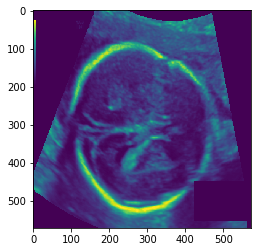

In [116]:
plt.imshow(p)

#preparing the U-net architecture

In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        


        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [0]:
class UNET(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNET, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [0]:
koshal = UNET(1,1)
koshal.to(device)

**In the above cell using "koshal" name as to represent U-Net model..**

# Using Loss Function

In [0]:
import torch.optim as optim

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(koshal.parameters(), lr=0.00015)

#Dice coefficient

In [0]:
def dice_coeff(y_pred, y_targets):
   
    
    smooth = 1
    num = y_targets.size(0)
    m1 = y_pred.view(num, -1)
    m2 = y_targets.view(num, -1)
    intersection = (m1 * m2)

    score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
    score = score.sum() / num
    return score.item()

In [0]:
def dice_loss(y_predict, y_train):
  
  dice_loss = 1 -(dice_coeff(y_predict, y_train))
  
  return dice_loss

#Training of the network

In [131]:
epochs = 10
train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0
  
  koshal.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train, y_train = sample_batched
    X_train= X_train.to(device)
    y_train= y_train.to(device)

    optimizer.zero_grad()
    y_pred = koshal(X_train)

    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
 
    loss.backward()
    optimizer.step()
    
    if ith_batch % 50 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()  
  else:
    with torch.no_grad():
      
      koshal.eval()
      
      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val, y_val = sample_batched
          X_val = X_val.to(device)
          y_val = y_val.to(device)
         
          y_out = koshal(X_val)
          out_val = (y_out + 0.5).int().float()
          
          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
           
          validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))
      
      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)
      
      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      print("================================================================================")
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)
  
  torch.cuda.empty_cache()

Epoch:  1 Batch:  0 Current Loss:  0.2568613290786743
Epoch:  1 Batch:  50 Current Loss:  0.5856524109840393
Epoch:  1 Batch:  100 Current Loss:  0.4563077688217163
Epoch:  1 Batch:  150 Current Loss:  0.3601243197917938
Epoch:  1 Batch:  200 Current Loss:  0.37025341391563416
Epoch:  1 Batch:  250 Current Loss:  0.28814467787742615
Epoch:  1 Batch:  300 Current Loss:  0.22266140580177307
Epoch:  1 Batch:  350 Current Loss:  0.5958904027938843
Epoch:  1 Batch:  400 Current Loss:  0.2841242849826813
Epoch 1 completed
Average train loss is 0.3605403808752696: 
Average validation loss is 0.31858385652303695
Epoch:  2 Batch:  0 Current Loss:  0.2296122908592224
Epoch:  2 Batch:  50 Current Loss:  0.24057361483573914
Epoch:  2 Batch:  100 Current Loss:  0.24831931293010712
Epoch:  2 Batch:  150 Current Loss:  0.21949738264083862
Epoch:  2 Batch:  200 Current Loss:  0.27898719906806946
Epoch:  2 Batch:  250 Current Loss:  0.1469455361366272
Epoch:  2 Batch:  300 Current Loss:  0.227990701794

#plot for validation & training loss respectively

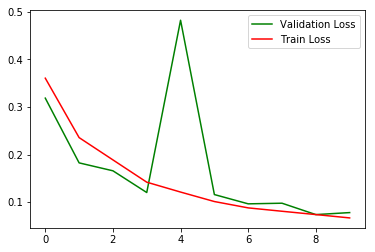

In [132]:
plt.plot(validation_running_loss_history, label = 'Validation Loss', color='green')
plt.plot(train_running_loss_history, label = 'Train Loss',  color='red')
plt.legend()

**We can see that both the losses are decreasing**

In [133]:
koshal.eval()
X_train.size()

torch.Size([1, 1, 572, 572])

In [0]:
out = (y_pred + 0.5).int().float()

In [144]:
print(dice_coeff(y_train, out))
print(dice_loss(y_train, out))

0.8360111117362976
0.1639888882637024


In [0]:
class HC18_test(Dataset):
    def __init__(self, root_dir, transform_X = None):
        self.pixel_file = test_pixel
        self.root_dir = root_dir
        self.transform_X = transform_X
        
    def __len__(self):
        return len(self.pixel_file)
    
    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, 'test_set', self.pixel_file.iloc[index, 0])
        
        imx = Image.open(imx_name)
        
        f_name = self.pixel_file.iloc[index, 0]
        
        if self.transform_X :
            imx = self.transform_X(imx)
        
        sample = {'image': imx, 'f_name': f_name}
        return sample

In [0]:
test_data = HC18_test('/content', transform_X = transform_X)

**Creating test-loader to work with test images**

In [0]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

In [0]:
def avg_dice_index(dataloader):
  
    dice = 0.0
    koshal.eval()
    with torch.no_grad():
    
        for ith_batch, sample_batched in enumerate(dataloader):
            X_train , y_train = sample_batched  
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            
            y_predict = (koshal(X_train) + 0.5).int().float()
            
            dice += dice_coeff(y_predict, y_train)
            
            
            
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [0]:
avg_dice_index(validation_loader)

In [0]:
avg_dice_index(train_loader)

In [0]:
test_loader = DataLoader(dataset = test_data, batch_size = 1, shuffle = True)

#Writing in the Drive

In [147]:
transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((540, 800)),transforms.ToTensor()])
    
with torch.no_grad():
    
      for ith_batch , data in enumerate(test_loader):
        X_test = data['image']
        X_test = X_test.to(device)
     
        y_pred = (koshal(X_test) + 0.5).int().float().cpu()
      
        file_names = data['f_name']
        Result = transform(y_pred[0])
        torchvision.utils.save_image(Result , os.path.join('/content/segmentation_test', file_names[0]))
      print("task to write file is complete")

task to write file is complete


**Function to create mask of test_set**

In [0]:
def test_ellipse(im):    
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

# **Function to fit ellipse into the test images**

In [150]:
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}

file_names = sorted([file for _,_,files in os.walk('/content/segmentation_test/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('/content/segmentation_test/'+file_name)
  
    ellipse = test_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1)
    image_name = file_name.split('.')[0] + '_Annotation_fit.png'
    
    pixel_size = test_pixel.loc[test_pixel['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    submission['angle_rad'].extend([np.deg2rad(angle)])
    
submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm', 
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]    
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("final_result.csv", index=False)
print('Required .csv file generated')

Required .csv file generated


In [0]:
final_result = pd.read_csv('/content/final_result.csv')

In [152]:
final_result.head()

,filename,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad
0,000_HC.png,93.694818,65.133791,53.575643,39.960896,3.117554
1,001_HC.png,29.686840,21.191104,11.573130,9.710746,2.625027
2,002_HC.png,60.545558,42.420483,38.290650,28.558594,0.078223
3,003_HC.png,35.148951,27.401620,30.386673,23.008445,3.130000
4,004_HC.png,78.535374,58.344917,54.529975,43.993122,0.118684


In [0]:
len(final_result)

335